# Additional examples

There is no comparison with ABACUS. 

1. `20.data` H2O with OpenMX
2. `30.data` Cdia with OpenMX
3. `40.data` Graphite with OpenMX

The results of the calculations for the three examples suggest that the interface works well for general systems.

## Table of contents

【Example1】H2O

1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
2. [Data preparation](#scrollTo=G-laa4YqQRji)
3. [Prepare input script](#scrollTo=G-laa4YqQRji)
4. [Train a model](#scrollTo=G-laa4YqQRji)
5. [Test a model](#scrollTo=G-laa4YqQRji)
6. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

【Example2】Cdia

1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
1. [Data preparation](#scrollTo=G-laa4YqQRji)
1. [Prepare input script](#scrollTo=G-laa4YqQRji)
1. [Train a model](#scrollTo=G-laa4YqQRji)
1. [Test a model](#scrollTo=G-laa4YqQRji)
1. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

【Example3】Graphite

1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
1. [Data preparation](#scrollTo=G-laa4YqQRji)
1. [Prepare input script](#scrollTo=G-laa4YqQRji)
1. [Train a model](#scrollTo=G-laa4YqQRji)
1. [Test a model](#scrollTo=G-laa4YqQRji)
1. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

In [31]:
import os
import dpdata
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ang2bohr = 1.88972612463
bohr2ang = 0.529177210903

## 【Example1】H2O

### 1.Get DFT data

The table shows bond length and angles mean value during MD.
|                  | reference | calculation | Error(%) |
|------------------|-----------|-------------|----------|
| bond length (Å)  | 0.9584    | 0.970       |    1.21  |
| bond angle (deg) | 104.45    | 103.62      |   0.62231|

length mean value = 0.97, angle mean value = 103.80


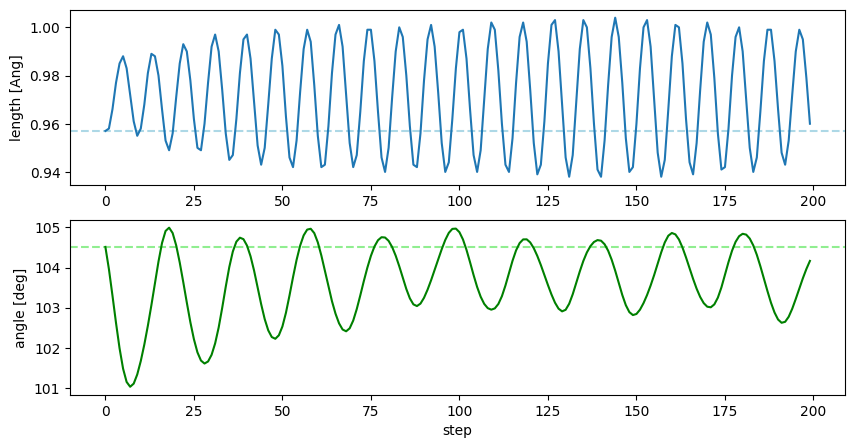

In [ ]:
data=np.genfromtxt(f"H2O.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(0.957,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1])
# ax1.plot(data[:,0], data[:,2])
# ax1.plot(data[:,0], data[:,3])

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(104.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,3],color="green")
# ax2.plot(data[:,0], data[:,5])
# ax2.plot(data[:,0], data[:,6])

# plt.savefig(f"geometry/H2O.png")
print(f"length mean value = {data[100:,1].mean():1.2f}, angle mean value = {data[100:,3].mean():3.2f}")
plt.show()

### 2.Data preparation

In [ ]:
label=2

In [ ]:
data = dpdata.LabeledSystem(f'{label}0.data/H2O', fmt = 'openmx') 
# data = dpdata.LabeledSystem('10.data/traj6', fmt = 'qe/cp/traj') 
print('# the data contains %d frames' % len(data))
# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=40,replace=False)     
# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')               
# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')           
print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation)) 

# the data contains 200 frames
# the training data contains 160 frames
# the validation data contains 40 frames


In [ ]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 3
Including Virials  : No
Element List       :
-------------------
O  H
1  2

### 3.Prepare input script

In [ ]:
# ! dp neighbor-stat -s 20.data -r 6.0 -t O H
! bash train.sh

first index = 2
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 0.9258628711099713
DEEPMD INFO    training data with max nbor size: [1 2]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd

### 4.Train a model

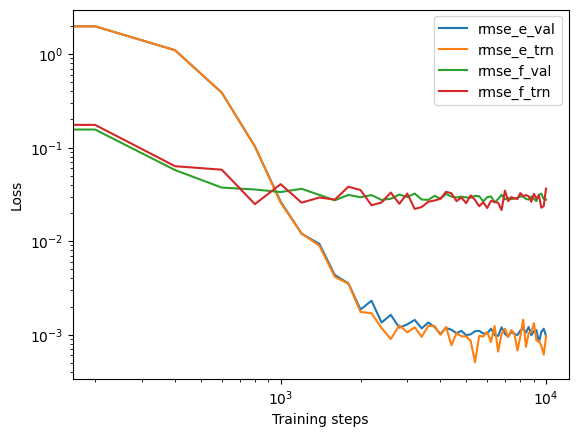

In [ ]:
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.test a model

In [ ]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

In [ ]:
training_systems["energies"]

array([-475.56659457, -475.5573427 , -475.52033522, -475.50863432,
       -475.53448514, -475.53992742, -475.51053912, -475.53502937,
       -475.56278498, -475.54536969, -475.51570928, -475.51462083,
       -475.5434649 , -475.51897465, -475.54509758, -475.53911107,
       -475.52659384, -475.55271677, -475.55951961, -475.53040343,
       -475.55162831, -475.553261  , -475.52142367, -475.53040343,
       -475.55162831, -475.55434945, -475.53856685, -475.54210433,
       -475.55707059, -475.55571002, -475.54292067, -475.54292067,
       -475.5573427 , -475.55489368, -475.54482547, -475.54972352,
       -475.55543791, -475.5475466 , -475.55026774, -475.56060807,
       -475.55843116, -475.55353311, -475.55598213, -475.55870327,
       -475.55897539, -475.55298888, -475.5475466 , -475.55271677,
       -475.55979173, -475.55353311, -475.55679848, -475.56060807,
       -475.54890717, -475.56060807, -475.55571002, -475.55217254,
       -475.55815904, -475.56224075, -475.55571002, -475.54999

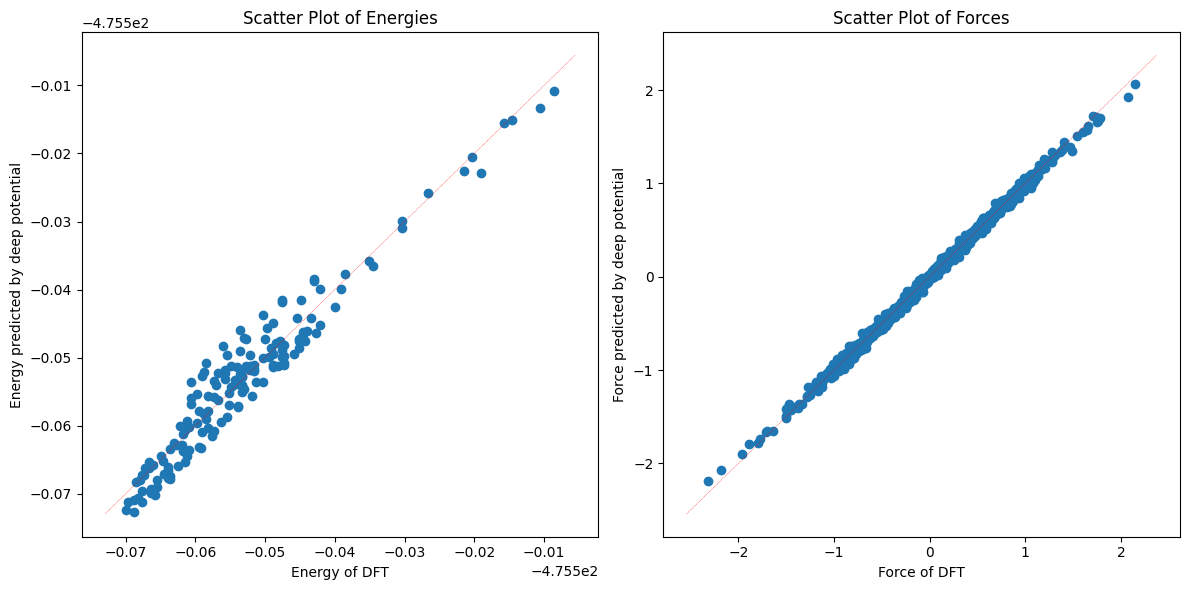

In [ ]:
plt.figure(figsize=(12, 6))

# 1つ目のプロット
plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.scatter(training_systems["forces"], predict["forces"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()


### 6.Run MD with ASE

In [ ]:
filename="H2O_nn"

In [ ]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")

! python3 H2O_MD.py > H2O_nn.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-27 02:20:03.550992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [ ]:
df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.000,-158.4803,-158.5218,0.0415,321.1
1,0.001,-158.4841,-158.5116,0.0275,212.8
2,0.002,-158.4766,-158.4943,0.0177,137.0
3,0.003,-158.4734,-158.4931,0.0198,152.9
4,0.004,-158.4698,-158.5032,0.0334,258.1
...,...,...,...,...,...
196,0.196,-158.4808,-158.5169,0.0360,278.8
197,0.197,-158.4777,-158.5133,0.0356,275.6
198,0.198,-158.4751,-158.5146,0.0396,306.1
199,0.199,-158.4759,-158.5147,0.0388,299.9


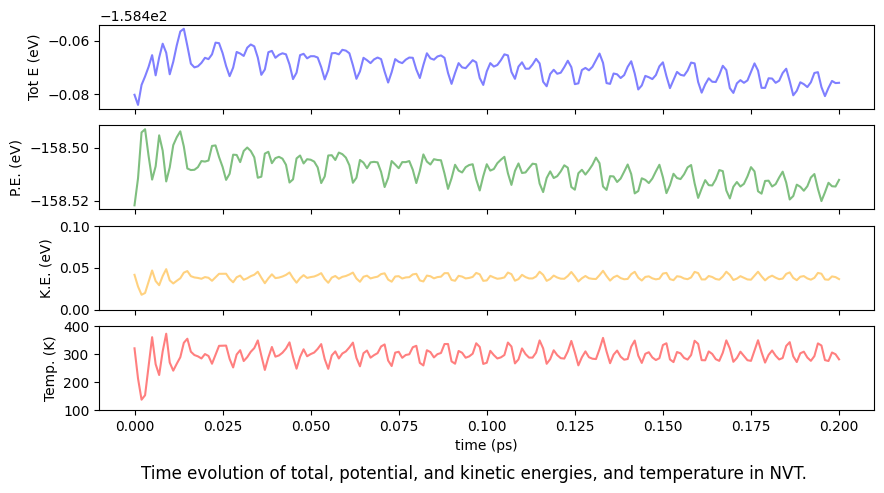

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

### 7.Bond length and bond angle

|                  | reference | OpenMX calculation | DeePMD calculation |
|------------------|-----------|-------------|----------|
| bond length (Å)  | 0.9584    | 0.970       |    0.97  |
| bond angle (deg) | 104.45    | 103.62      |   103.69|

length mean value = 0.97, angle mean value = 103.84


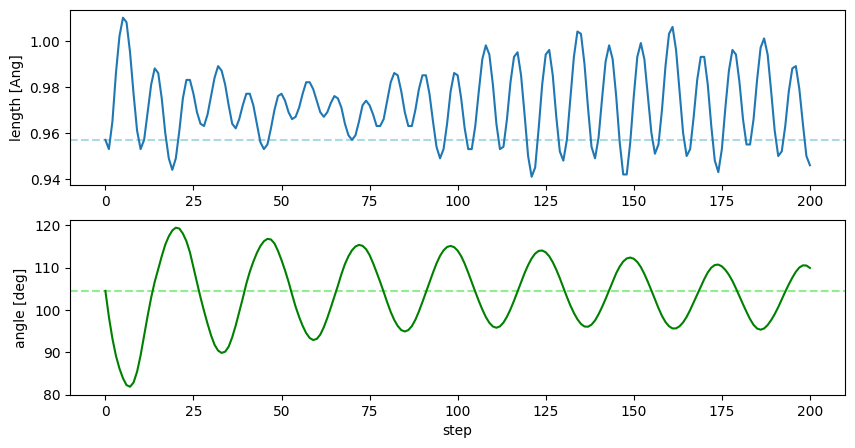

In [ ]:
data=np.genfromtxt(f"{filename}.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(0.957,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1])
# ax1.plot(data[:,0], data[:,2])
# ax1.plot(data[:,0], data[:,3])

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(104.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,3],color="green")
# ax2.plot(data[:,0], data[:,5])
# ax2.plot(data[:,0], data[:,6])

# plt.savefig(f"geometry/{filename}.png")
print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,3].mean():3.2f}")
plt.show()

      Step     Time          Energy         fmax
BFGS:    0 15:00:16     -475.462352        1.2347
length[Å] length[Å] angle[deg]
0.9584   0.9584   90.00
BFGS:    1 15:00:16     -475.496212        0.7816
length[Å] length[Å] angle[deg]
0.9707   0.9707   91.51
BFGS:    2 15:00:16     -475.556345        0.9133
length[Å] length[Å] angle[deg]
0.9802   0.9802   98.59
BFGS:    3 15:00:16     -475.570202        0.4513
length[Å] length[Å] angle[deg]
0.9761   0.9761   102.50
BFGS:    4 15:00:16     -475.572782        0.0525
length[Å] length[Å] angle[deg]
0.9703   0.9703   103.78
BFGS:    5 15:00:16     -475.572816        0.0005


/opt/homebrew/lib/python3.11/site-packages/ase/visualize/plot.py:59: UserWarning: You passed in an explicit save_count=100 which is being ignored in favor of len(frames)=6.
  animation = FuncAnimation(fig, drawimage, frames=images,


length[Å] length[Å] angle[deg]
0.9695   0.9695   103.91


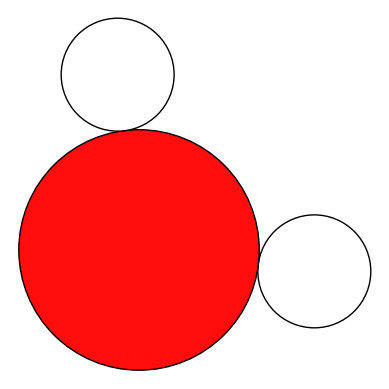

In [ ]:
from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.emt import EMT
from deepmd.calculator import DP
import numpy as np
from ase.md import MDLogger
from ase.io import write,Trajectory
d = 0.9584 ## 0.9584
t = np.pi / 180 * 90 ## 104.45
water = Atoms('H2O',
              positions=[(d, 0, 0),
                         (d * np.cos(t), d * np.sin(t), 0),
                         (0, 0, 0)])
label=2
water.set_calculator(DP(model=f"{label}1.train/graph.pb"))
dyn = BFGS(water, trajectory="H2O.traj")

def calculate_angle(v1, v2):
    # ベクトルv1とv2の内積を計算
    dot_product = np.dot(v1, v2)
    
    # ベクトルv1とv2のノルムを計算
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # アークコサインを使用して角度を計算
    angle_rad = np.arccos(dot_product / (norm_v1 * norm_v2))
    
    # ラジアンから度に変換
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def myprint():
    vec1=water.positions[0]-water.positions[2]
    vec2=water.positions[1]-water.positions[2]

    print("length[Å] length[Å] angle[deg]")
    print(f'{np.linalg.norm(vec1):5.4f}   '+f'{np.linalg.norm(vec2):5.4f}   '+f'{calculate_angle(vec1,vec2):3.2f}')
dyn.attach(myprint, interval=1)
dyn.run(fmax=0.05)
traj=Trajectory("H2O.traj")
write(f"H2O.gif", traj[::1], rotation="0x,0y,0z")

## 【Example2】Cdia

In [37]:
label=3

In [ ]:
data = dpdata.LabeledSystem(f'{label}0.data/Cdia', fmt = 'openmx') 
# data = dpdata.LabeledSystem('10.data/traj6', fmt = 'qe/cp/traj') 
print('# the data contains %d frames' % len(data))
# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=100,replace=False)     
# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')               
# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')           
print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation)) 

# the data contains 1000 frames
# the training data contains 900 frames
# the validation data contains 100 frames


In [ ]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 900
Atom Numbers       : 16
Including Virials  : No
Element List       :
-------------------
C
16

### 3.Prepare input script

Serial training (not parallel)

In [ ]:
# ! dp neighbor-stat -s 30.data -r 6.0 -t C
! bash train.sh

first index = 2
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 0.9258628711099713
DEEPMD INFO    training data with max nbor size: [1 2]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd

### 4.Train a model

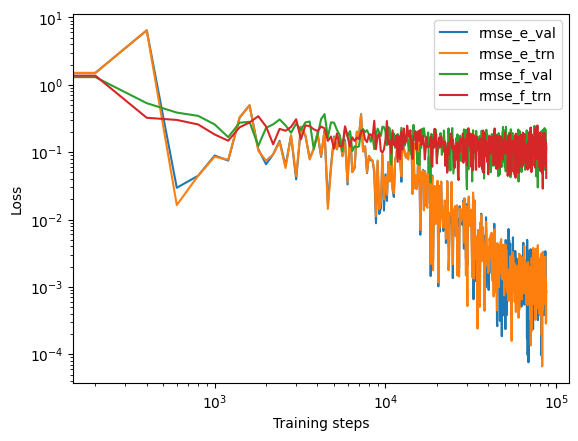

In [38]:
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.test a model

For detail of the warnings, please check [Discussions #221](https://github.com/deepmodeling/deepmd-kit/discussions/221).

In [43]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 


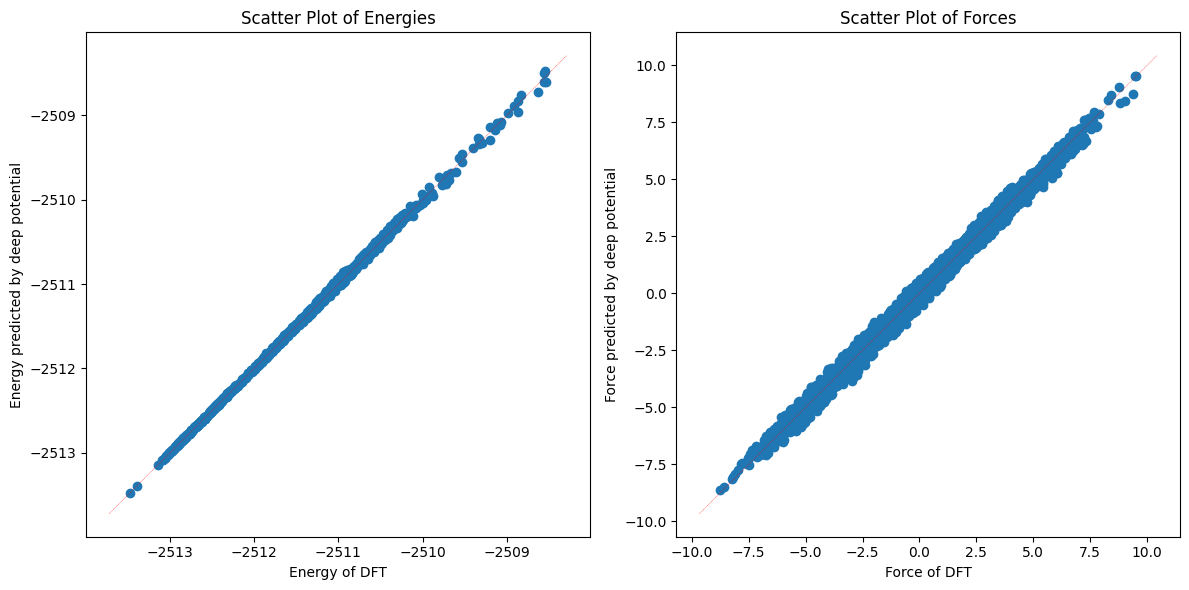

In [44]:
plt.figure(figsize=(12, 6))

# 1つ目のプロット
plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.scatter(training_systems["forces"], predict["forces"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()


### 6.Run MD with ASE

In [41]:
filename="Cdia"

In [48]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")
    
! python3 Cdia_MD.py

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-27 15:19:16.899077: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of lower bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound

In [49]:
df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.000,-157.0390,-157.0924,0.0533,412.5
1,0.001,-157.0412,-157.0899,0.0487,377.0
2,0.002,-157.0396,-157.0832,0.0435,336.8
3,0.003,-157.0378,-157.0736,0.0358,277.3
4,0.004,-157.0356,-157.0634,0.0278,215.4
...,...,...,...,...,...
196,0.196,-156.9299,-157.0063,0.0764,590.9
197,0.197,-156.9301,-157.0250,0.0948,733.6
198,0.198,-156.9312,-157.0425,0.1112,860.4
199,0.199,-156.9331,-157.0548,0.1217,941.4


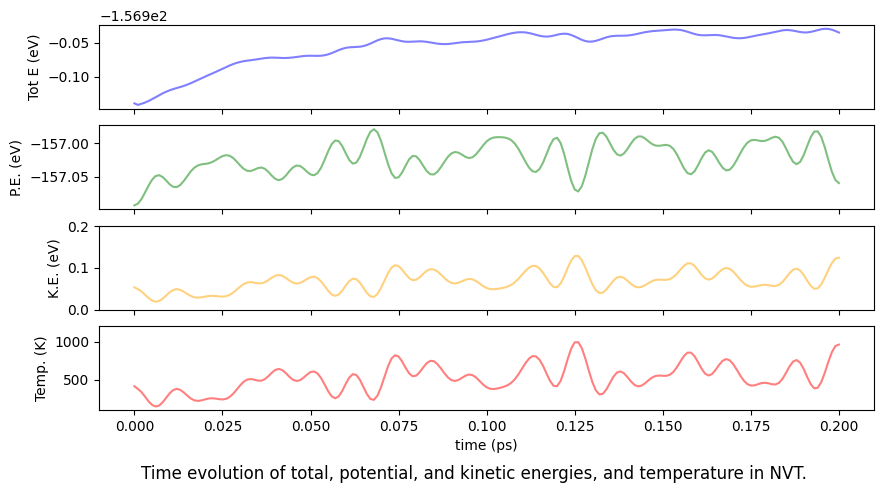

In [50]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.2])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100.,1200])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

atomic positions at first[Å]
[[0.         0.         0.        ]
 [0.96612126 0.86154409 0.98838338]
 [1.63953825 1.76932639 0.        ]
 [2.51937778 2.80540559 0.92306054]
 [1.64723419 0.         1.97059209]
 [2.88251702 0.81848244 2.78811451]
 [3.28466674 1.85072643 1.77399773]
 [4.30648    2.62425988 2.72509707]
 [0.         1.66105522 1.54482529]
 [0.87579829 2.57750345 2.67392384]
 [1.90032489 3.42579514 1.69288854]
 [2.68303034 4.59825046 2.57393139]
 [1.65230025 1.79619175 3.63543566]
 [2.87181267 2.74991905 4.70785387]
 [3.53394469 3.75656144 3.62157737]
 [4.70589812 4.44032839 4.19206769]]
      Step     Time          Energy         fmax
BFGS:    0 15:55:29    -2499.566323       12.0373
BFGS:    1 15:55:29    -2508.075347        6.9928
BFGS:    2 15:55:29    -2509.891673        4.5638
BFGS:    3 15:55:30    -2510.800795        2.1429
BFGS:    4 15:55:30    -2511.166344        1.6214
BFGS:    5 15:55:30    -2511.466006        3.9532
BFGS:    6 15:55:30    -2511.622795        6.

/opt/homebrew/lib/python3.11/site-packages/ase/visualize/plot.py:59: UserWarning: You passed in an explicit save_count=100 which is being ignored in favor of len(frames)=18.
  animation = FuncAnimation(fig, drawimage, frames=images,


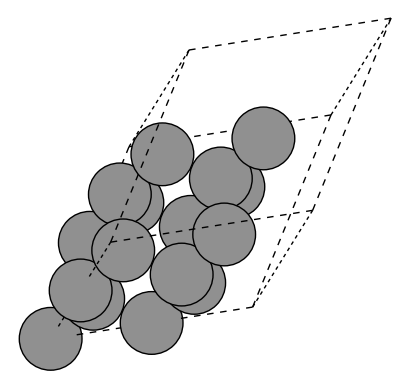

In [86]:
from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.emt import EMT
from deepmd.calculator import DP
import numpy as np
from ase.md import MDLogger
from ase.io import write,Trajectory
from ase.build import bulk

d = 0.25

Cdia = bulk(name="C", crystalstructure="diamond", a=3.56).repeat((2,2,2))
random_factor=np.random.normal(1.0,0.05,(16,3)) # N(1.0, 0.05) size=(16,3)
Cdia.positions=Cdia.positions*random_factor
# print(random_factor)
# print(Cdia.positions)
# cdia = Atoms('C16',
#               positions=[(0.0, 0.0, 0.0),
#                          (-a,  a,  b),
#                          ( a, -a,  b),
#                          ( a,  a, -b),
#                          (-a, -a,  b)])
label=3
Cdia.set_calculator(DP(model=f"{label}1.train/graph.pb"))
dyn = BFGS(Cdia, trajectory="Cdia.traj")

# def myprint():
#       print("atomic positions[Å]")
#       print(Cdia.positions)

# dyn.attach(myprint, interval=1)
print("atomic positions at first[Å]")
print(Cdia.positions)
dyn.run(fmax=0.05)
print("atomic positions at final[Å]")
print(Cdia.positions)
traj=Trajectory("Cdia.traj")
write(f"Cdia.gif", traj[::1], rotation="30x,30y,30z")

In [88]:
# Cdia = bulk(name="C", crystalstructure="diamond", a=3.56).repeat((2,2,2))
# Cdia.positions

array([[0.  , 0.  , 0.  ],
       [0.89, 0.89, 0.89],
       [1.78, 1.78, 0.  ],
       [2.67, 2.67, 0.89],
       [1.78, 0.  , 1.78],
       [2.67, 0.89, 2.67],
       [3.56, 1.78, 1.78],
       [4.45, 2.67, 2.67],
       [0.  , 1.78, 1.78],
       [0.89, 2.67, 2.67],
       [1.78, 3.56, 1.78],
       [2.67, 4.45, 2.67],
       [1.78, 1.78, 3.56],
       [2.67, 2.67, 4.45],
       [3.56, 3.56, 3.56],
       [4.45, 4.45, 4.45]])

In [87]:
# Cdia.positions

array([[-0.00826958,  0.00850033,  0.01319877],
       [ 0.88118437,  0.89863057,  0.90328573],
       [ 1.7713689 ,  1.78789328,  0.01281405],
       [ 2.66139462,  2.67819967,  0.90276058],
       [ 1.77156659,  0.00826064,  1.79329018],
       [ 2.66197231,  0.89818857,  2.68357966],
       [ 3.5515779 ,  1.78822581,  1.79326447],
       [ 4.44178194,  2.67796807,  2.6831069 ],
       [-0.00827723,  1.78914891,  1.79302634],
       [ 0.88222112,  2.67876475,  2.68339023],
       [ 1.77210592,  3.56848625,  1.79321754],
       [ 2.66216291,  4.45848496,  2.68293138],
       [ 1.77217919,  1.78852213,  3.57376759],
       [ 2.66177733,  2.67887715,  4.46305031],
       [ 3.55225436,  3.56855681,  3.57320106],
       [ 4.44204385,  4.45864182,  4.46386419]])

## 【Example3】Graphite

In [100]:
label=4

In [93]:
data = dpdata.LabeledSystem(f'{label}0.data/Graphite', fmt = 'openmx') 
# data = dpdata.LabeledSystem('10.data/traj6', fmt = 'qe/cp/traj') 
print('# the data contains %d frames' % len(data))
# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=100,replace=False)     
# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')               
# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')           
print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation)) 

# the data contains 1000 frames
# the training data contains 900 frames
# the validation data contains 100 frames


In [94]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 900
Atom Numbers       : 32
Including Virials  : No
Element List       :
-------------------
C
32

### 3.Prepare input script

Serial training (not parallel)

In [98]:
# ! dp neighbor-stat -s 40.data -r 6.0 -t C
# ! bash train.sh

first index = 4
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 1.2595161602774283
DEEPMD INFO    training data with max nbor size: [40]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd.

### 4.Train a model

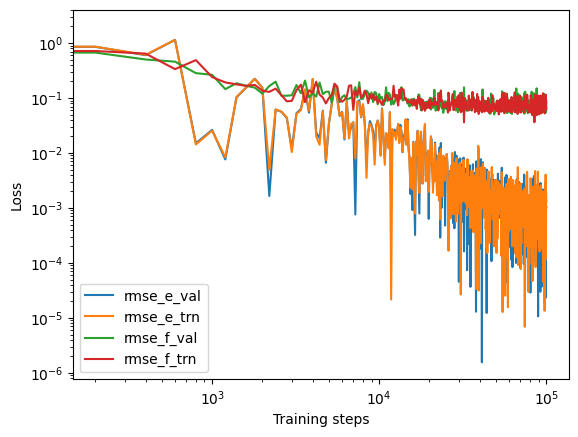

In [101]:
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.test a model

For detail of the warnings, please check [Discussions #221](https://github.com/deepmodeling/deepmd-kit/discussions/221).

In [102]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

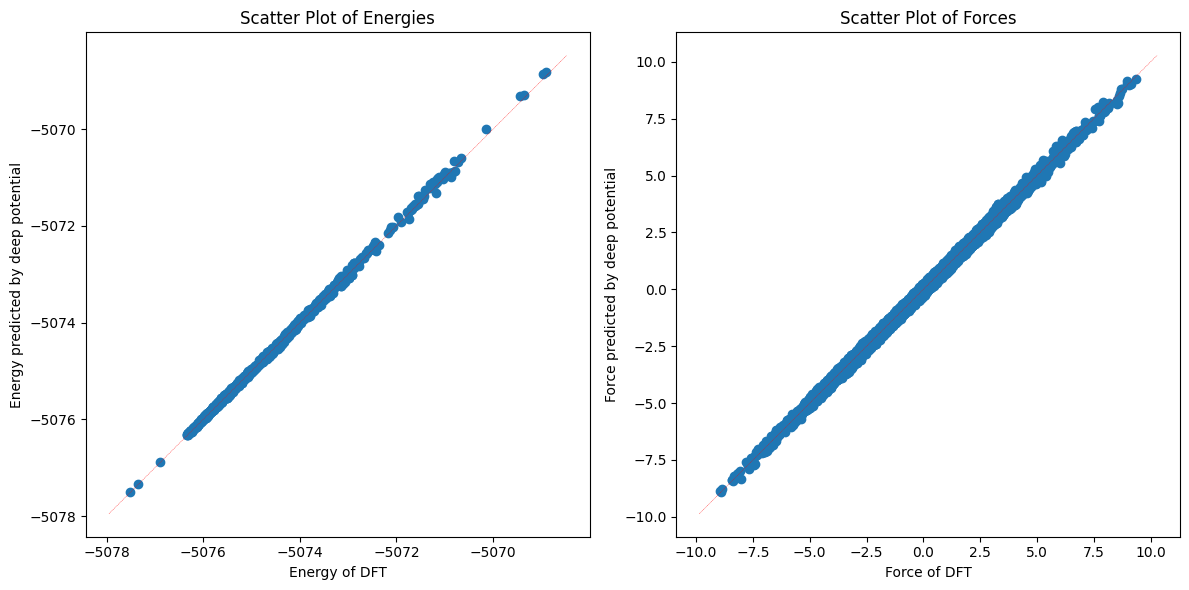

In [103]:
plt.figure(figsize=(12, 6))

# 1つ目のプロット
plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.scatter(training_systems["forces"], predict["forces"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()


### 6.Run MD with ASE

In [104]:
filename="Graphite"

In [111]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")
    
! python3 Graphite_MD.py

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-27 18:06:19.028024: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))
time=    0 fs T= 540 K
time=    1 fs T= 507 K
time=    2 fs T= 460 K
time=    3 fs T= 394 K
time=    4 fs T= 326 K
time=    5 fs T= 274 K
time=    6 fs T= 248 K
time=    7 fs T= 254 K
time=    8 fs T= 285 K
time=    9 fs T= 330 K
time=   10 fs T= 371 K
time=   11 fs T= 397 K
time=   12 fs T= 399 K
time=   13 fs T= 379 K
time=   14 fs T= 346 K
time=   15 fs T= 313 K
time=   16 fs T= 292 K
time=   17 fs T= 295 K
time=   18 fs T= 326 K
time=   19

In [112]:
df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.000,-158.5480,-158.6178,0.0698,539.9
1,0.001,-158.5496,-158.6151,0.0656,507.2
2,0.002,-158.5483,-158.6078,0.0595,460.1
3,0.003,-158.5463,-158.5972,0.0509,393.6
4,0.004,-158.5435,-158.5856,0.0421,326.0
...,...,...,...,...,...
196,0.196,-158.4641,-158.5249,0.0608,470.0
197,0.197,-158.4624,-158.5236,0.0612,473.4
198,0.198,-158.4608,-158.5270,0.0661,511.5
199,0.199,-158.4598,-158.5340,0.0742,574.2


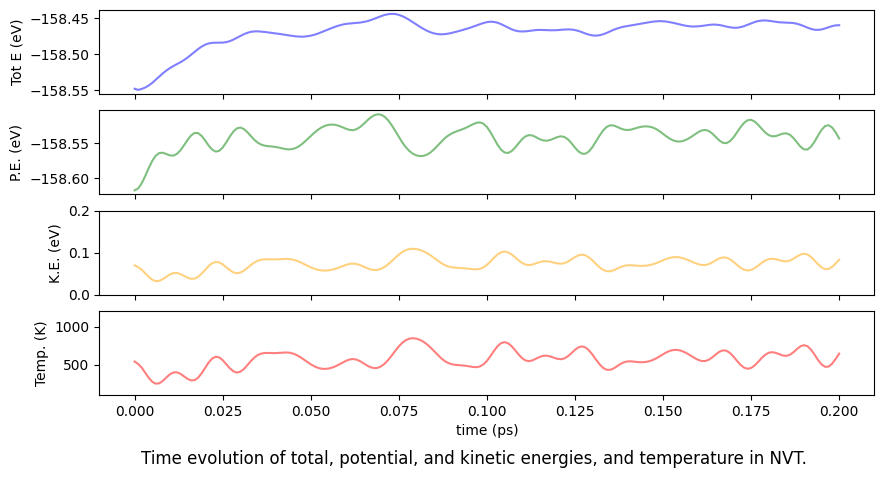

In [113]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.2])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100.,1200])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

atomic positions at first[Å]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.13857476e-16  1.50796677e+00  0.00000000e+00]
 [ 6.53901055e-16  1.32173236e+00  5.03099600e+00]
 [ 1.15952889e+00  6.60330024e-01  5.03049638e+00]
 [ 2.28508001e+00  0.00000000e+00  0.00000000e+00]
 [ 2.51666731e+00  1.51901783e+00  0.00000000e+00]
 [ 2.46654441e+00  1.46446992e+00  5.03068463e+00]
 [ 3.76584142e+00  6.61430129e-01  4.67126179e+00]
 [-1.23590821e+00  2.10935349e+00  0.00000000e+00]
 [-1.27590667e+00  3.65346279e+00  0.00000000e+00]
 [-1.22636070e+00  3.71791988e+00  4.98739998e+00]
 [ 6.54913844e-16  2.99197098e+00  5.00233496e+00]
 [ 1.27512286e+00  2.13349412e+00  0.00000000e+00]
 [ 1.21155353e+00  3.57295738e+00  0.00000000e+00]
 [ 1.29838152e+00  3.52421107e+00  5.25468831e+00]
 [ 2.23142415e+00  2.80591666e+00  4.72128254e+00]]
      Step     Time          Energy         fmax
BFGS:    0 18:11:46    -2528.979432       14.6777
BFGS:    1 18:11:46    -2534.210812        8.9599
BFGS:

/opt/homebrew/lib/python3.11/site-packages/ase/visualize/plot.py:59: UserWarning: You passed in an explicit save_count=100 which is being ignored in favor of len(frames)=12.
  animation = FuncAnimation(fig, drawimage, frames=images,


atomic positions at final[Å]
[[-0.01787748  0.03667999 -0.00909503]
 [-0.01791233  1.45698089 -0.00903872]
 [-0.01806382  1.43341688  4.9739467 ]
 [ 1.21199108  0.72307862  4.97554428]
 [ 2.44201957  0.03659364 -0.00883707]
 [ 2.4421082   1.4569204  -0.00888014]
 [ 2.44190909  1.43344364  4.97746914]
 [ 3.67193408  0.72312669  4.97492257]
 [-1.24788731  2.16707438 -0.00900159]
 [-1.24793564  3.58738969 -0.00901251]
 [-1.24819845  3.56407732  4.97400495]
 [-0.01811808  2.85350287  4.97289043]
 [ 1.2121687   2.16709415 -0.00887495]
 [ 1.21202081  3.58741135 -0.00896826]
 [ 1.21182994  3.56375244  4.97594589]
 [ 2.44198017  2.85369043  4.97612892]]


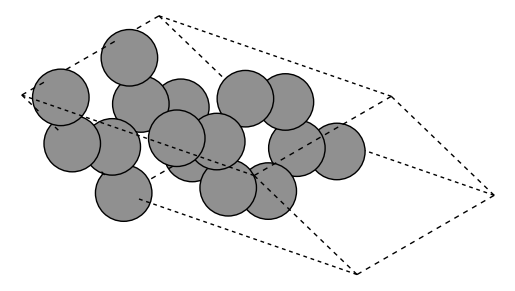

In [118]:
from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.emt import EMT
from deepmd.calculator import DP
import numpy as np
from ase.md import MDLogger
from ase.io import write,Trajectory
from ase.build import bulk
from ase.lattice.hexagonal import *

index1=2
index2=2
a = 2.46
c = 10.0 

stacks = 1

atoms = Graphite(symbol = 'C',latticeconstant={'a':a,'c':c},size=(index1,index2,stacks))

random_factor=np.random.normal(1.0,0.05,(16,3)) # N(1.0, 0.05) size=(16,3)
atoms.positions=atoms.positions*random_factor
# print(random_factor)
# print(Graphite.positions)
# Graphite = Atoms('C16',
#               positions=[(0.0, 0.0, 0.0),
#                          (-a,  a,  b),
#                          ( a, -a,  b),
#                          ( a,  a, -b),
#                          (-a, -a,  b)])
label=4
atoms.set_calculator(DP(model=f"{label}1.train/graph.pb"))
dyn = BFGS(atoms, trajectory="Graphite.traj")

# def myprint():
#       print("atomic positions[Å]")
#       print(Graphite.positions)

# dyn.attach(myprint, interval=1)
print("atomic positions at first[Å]")
print(atoms.positions)
dyn.run(fmax=0.05)
print("atomic positions at final[Å]")
print(atoms.positions)
traj=Trajectory("Graphite.traj")
write(f"Graphite.gif", traj[::1], rotation="30x,30y,30z")

##
The workflow of DeePMD-kit is normally completed in the three example above.